#### *Applied Mathematical Finance 2*

## <ins> *Seminar 6: FX Derivatives* </ins>

### 1. FX forward

Dealing with FX market, we have to cope with multiple currenceis. For the sake of simplicity, hereinafter we will use only two currecies: $\text{DOM}$ (domestic) and $\text{FOR}$ (foreign). Therefore, we may define the discount factors correposnding to each currency (assuming deterministic interest rates and continuous compounding convention)

$$\text{DF}^{\text{DOM}}(t, T) = e^{-\int_{t}^{T}r_D(s)ds}, \quad \text{DF}^{\text{FOR}}(t, T) = e^{-\int_{t}^{T}r_F(s)ds}.$$

Obviosuly we also face with a spot FX $X^{\text{FORDOM}}_t$ associated with given currencies $\text{DOM}$ and $\text{FOR}$, which expresses the number of units of $\text{DOM}$ currency per $1$ unit of $\text{FOR}$ currencies. 

The arbitrage-free FX forward rate (assuming zero settlement lags) can be given by 

$$F^{\text{FORDOM}}(t, T) = X^{\text{FORDOM}}_t \cdot \dfrac{\text{DF}^{\text{FOR}}(t, T)}{\text{DF}^{\text{DOM}}(t, T)}.$$


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize_scalar
import warnings
warnings.filterwarnings('ignore')

In [2]:
def extract_data_for_df_curves(dfs_data_path: str):
    """
    Extracts the data from given .csv file for corresponding discount factors curve.

    Args:
        dfs_data_path: absolute (or relative) path to discount factors .csv file. 
    """
    dfs = pd.read_csv(dfs_data_path)
    dom_discount_factors = dict(zip(dfs["Dates"], dfs["DOM_DFs"]))
    for_discount_factors = dict(zip(dfs["Dates"], dfs["FOR_DFs"]))

    return dom_discount_factors, for_discount_factors

In [3]:
rub_discount_factors, usd_discount_factors = extract_data_for_df_curves("data/DOM_AND_FOR_DFS.csv")

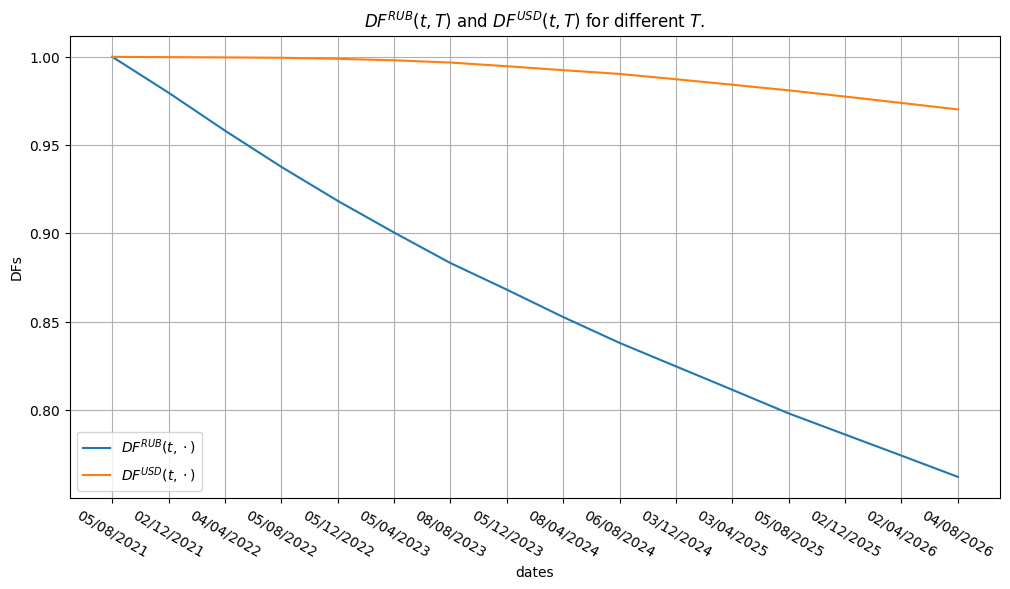

In [4]:
step = 21 * 4 # plot each 4 months

plt.figure(figsize=(12, 6))
plt.title("$DF^{RUB}(t, T)$ and $DF^{USD}(t, T)$ for different $T$.")
plt.plot(list(rub_discount_factors.keys())[::step], list(rub_discount_factors.values())[::step], label="$DF^{RUB}(t, \cdot)$")
plt.plot(list(usd_discount_factors.keys())[::step], list(usd_discount_factors.values())[::step], label="$DF^{USD}(t, \cdot)$")
plt.xlabel("dates")
plt.ylabel("DFs")
plt.xticks(rotation=-30)
plt.grid()
plt.legend()
plt.show()

In [5]:
def fx_forward(X_ref: float, DF_DOM: dict, DF_FOR: dict):
    """
    Calculates the FX forward F(t, T).  

    Args: 
        S_ref: spot value. 
        DF_DOM: a mapping from date to DOM discount factor. 
        DF_FOR: a mapping from date to FOR discount factor. 
    """
    dom_dates, for_dates = DF_DOM.keys(), DF_FOR.keys()
    assert dom_dates == for_dates, "Dates for FOR and DOM DFs mismatch."

    forward = dict()
    for date, df_dom in DF_DOM.items():
        forward[date] = X_ref * DF_FOR[date] / df_dom
    return forward


In [6]:
value_date = "05/08/2021"
X_ref = 73.047
USDRUB_forward = fx_forward(X_ref = X_ref, DF_DOM=rub_discount_factors, DF_FOR=usd_discount_factors)

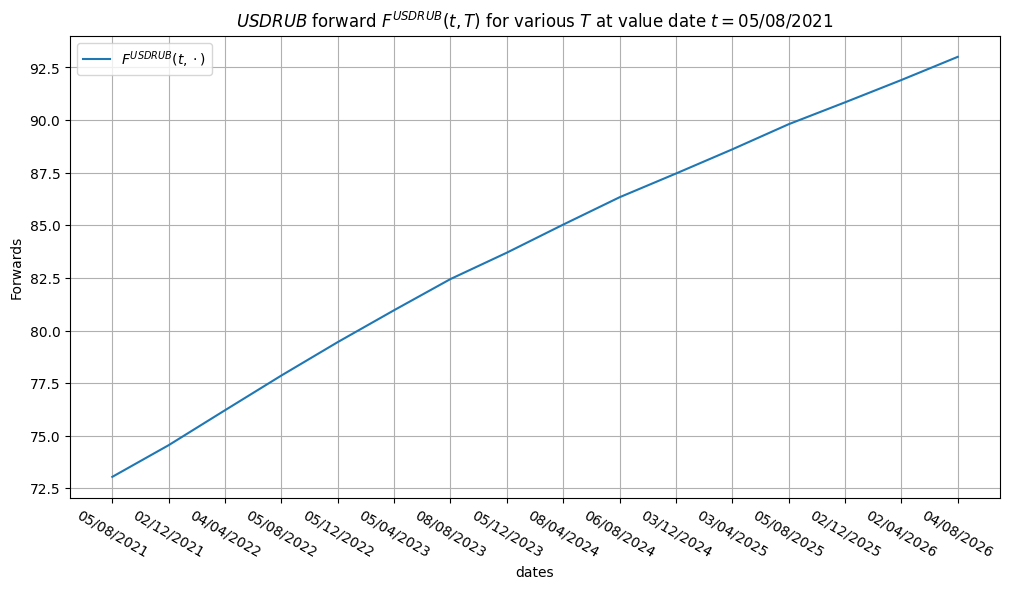

In [7]:
step = 21 * 4 # plot each 4 months

plt.figure(figsize=(12, 6))
plt.title("$USDRUB$ forward $F^{USDRUB}(t, T)$ for various $T$ at value date $t=$" + value_date)
plt.plot(list(USDRUB_forward.keys())[::step], list(USDRUB_forward.values())[::step], label="$F^{USDRUB}(t, \cdot)$")
plt.xlabel("dates")
plt.ylabel("Forwards")
plt.xticks(rotation=-30)
plt.grid()
plt.legend()
plt.show()

### 2. FX Volatility Surface

Volatility surface can be retrieved  from the observed market quotes of vanilla
instruments. Contrary to equity options where we observe the implied volatility for a given
strike and expiry date, FX volatility smiles are quoted in terms of vanilla strategies such as risk
reversals (RR) and butterflies (BF).

$\cdot$  **Risk reversal** investment strategy (RR) is an option position that consists of selling (that is, being short) an out of the money put and buying (i.e. being long) an out of the money call, both options expiring on the same expiration date. FX options are usually quoted in **10-RR** and **25-RR**, that is 

$$\sigma_{25-RR} = \sigma_{25-C} - \sigma_{25-P}, \quad \sigma_{10-RR} = \sigma_{10-C} - \sigma_{10-P},$$

where $\sigma_{25-RR}$ (resp., $\sigma_{10-RR}$) is the difference in volatility between a call option with delta of $0.25$ (resp., $0.15$) and a put option with a delta of $-0.25$ (resp., $-0.1$). 

A positive risk reversal means the implied volatility of calls is greater than the implied volatility of similar puts, which implies a 'positively' skewed distribution of expected spot returns. 

$\cdot$  **Butterfly** investment strategy (BF) is an option position that consists of selling two at the money options and buying an out of the money call and out of the money put with the same strikes, all options expiring on the same expiration date. FX options are usually quoted in **10-BF** and **25-BF**, that is 

$$\sigma_{25-BF} = \frac{\sigma_{25-C} + \sigma_{25-P} - 2 \sigma_{ATM}}{2}, \quad  \sigma_{10-BF} = \frac{\sigma_{10-C} + \sigma_{10-P} - 2 \sigma_{ATM}}{2}.$$

A positive butterfly means the implied volatility smile is convex. 

In [8]:
def extract_data_for_volatility_surface(vol_data_path: str):
    """
    Extracts the data from given .csv file for corresponding volatility quotes.

    Args:
        vol_data_path: absolute (or relative) path to volatility quotes .csv file. 
    """
    return pd.read_csv(vol_data_path)

In [9]:
vol_data = extract_data_for_volatility_surface("data/FX_VOL.csv")
vol_data

,Dates,Periods,10BF,25BF,ATM,25RR,10RR
0,19/08/2021,2W,0.009875,0.0031,0.09500,0.0220,0.04400
1,26/08/2021,3W,0.010625,0.0033,0.09625,0.0220,0.04510
2,06/09/2021,1M,0.011375,0.0035,0.09750,0.0220,0.04620
3,05/10/2021,2M,0.013000,0.0040,0.10300,0.0250,0.05250
4,05/11/2021,3M,0.014625,0.0045,0.10500,0.0285,0.05985
5,07/02/2022,6M,0.019500,0.0060,0.11100,0.0315,0.06615
6,05/05/2022,9M,0.021125,0.0065,0.11550,0.0335,0.07035
7,05/08/2022,1Y,0.022750,0.0070,0.11900,0.0360,0.07560
8,07/08/2023,2Y,0.026000,0.0080,0.12100,0.0375,0.07875
9,05/08/2024,3Y,0.027625,0.0085,0.12300,0.0385,0.08085


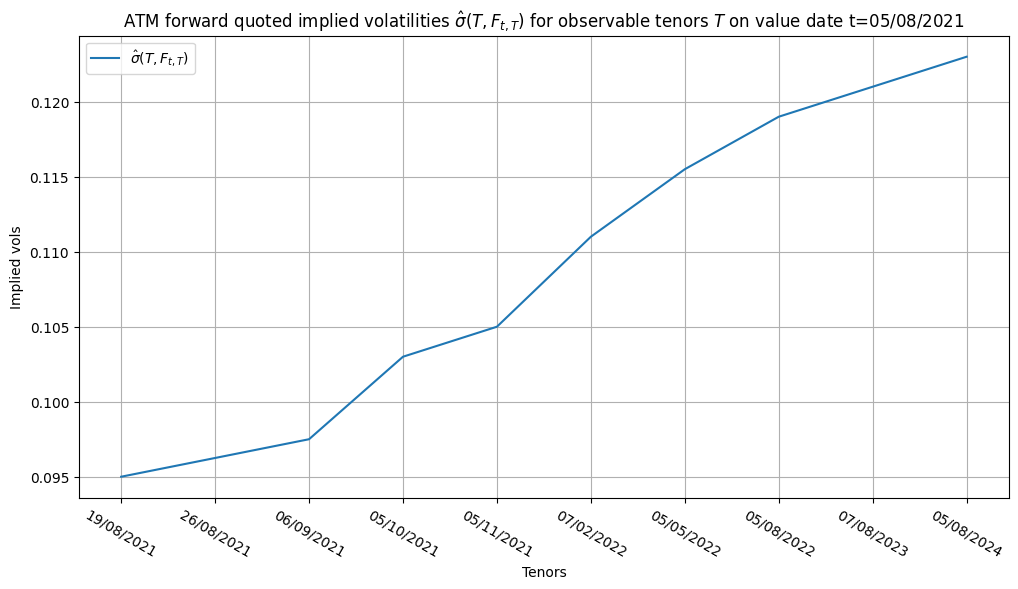

In [10]:
plt.figure(figsize=(12, 6))
plt.title("ATM forward quoted implied volatilities $\hat\sigma(T, F_{t, T})$ for observable tenors $T$ on value date t=" + value_date)
plt.plot(vol_data["Dates"], vol_data["ATM"], label="$\hat\sigma(T, F_{t, T})$")
plt.xlabel("Tenors")
plt.ylabel("Implied vols")
plt.xticks(rotation=-30)
plt.grid()
plt.legend()
plt.show()

From the given system of equations

$$\sigma_{25-RR} = \sigma_{25-C} - \sigma_{25-P}, \quad \sigma_{10-RR} = \sigma_{10-C} - \sigma_{10-P},$$

$$\sigma_{25-BF} = \frac{\sigma_{25-C} + \sigma_{25-P} - 2 \sigma_{ATM}}{2}, \quad  \sigma_{10-BF} = \frac{\sigma_{10-C} + \sigma_{10-P} - 2 \sigma_{ATM}}{2}.$$

we can easily find the solutions 

$$\sigma_{25-C} = \sigma_{25-BF} + \sigma_{ATM} + 0.5 \cdot \sigma_{25-RR}, \quad \sigma_{10-C} = \sigma_{10-BF} + \sigma_{ATM} + 0.5 \cdot \sigma_{10-RR},$$

$$\sigma_{10-P} = \sigma_{10-BF} + \sigma_{ATM} - 0.5 \cdot \sigma_{10-RR}, \quad \sigma_{25-P} = \sigma_{25-BF} + \sigma_{ATM} - 0.5 \cdot \sigma_{25-RR}.$$

In [11]:
def extract_10_and_25_delta_volatilities(vol_data: pd.DataFrame):
    """
    Computes the 10 and 25 delta volatilities from given volatility data. 

    Args:
        vol_data: a dataframe with volatility strategies quotes. 
    """

    volatilities_per_delta = pd.DataFrame()
    volatilities_per_delta["Dates"] = vol_data["Dates"]
    volatilities_per_delta["Periods"] = vol_data["Periods"]
    volatilities_per_delta["10P"] = vol_data["10BF"] + vol_data["ATM"] - 0.5 * vol_data["10RR"]
    volatilities_per_delta["25P"] = vol_data["25BF"] + vol_data["ATM"] - 0.5 * vol_data["25RR"]
    volatilities_per_delta["ATM"] = vol_data["ATM"]
    volatilities_per_delta["25C"] = vol_data["25BF"] + vol_data["ATM"] + 0.5 * vol_data["25RR"]
    volatilities_per_delta["10C"] = vol_data["10BF"] + vol_data["ATM"] + 0.5 * vol_data["10RR"]

    return volatilities_per_delta

In [12]:
volatiltiies = extract_10_and_25_delta_volatilities(vol_data=vol_data)
volatiltiies

,Dates,Periods,10P,25P,ATM,25C,10C
0,19/08/2021,2W,0.082875,0.08710,0.09500,0.10910,0.126875
1,26/08/2021,3W,0.084325,0.08855,0.09625,0.11055,0.129425
2,06/09/2021,1M,0.085775,0.09000,0.09750,0.11200,0.131975
3,05/10/2021,2M,0.089750,0.09450,0.10300,0.11950,0.142250
4,05/11/2021,3M,0.089700,0.09525,0.10500,0.12375,0.149550
5,07/02/2022,6M,0.097425,0.10125,0.11100,0.13275,0.163575
6,05/05/2022,9M,0.101450,0.10525,0.11550,0.13875,0.171800
7,05/08/2022,1Y,0.103950,0.10800,0.11900,0.14400,0.179550
8,07/08/2023,2Y,0.107625,0.11025,0.12100,0.14775,0.186375
9,05/08/2024,3Y,0.110200,0.11225,0.12300,0.15075,0.191050


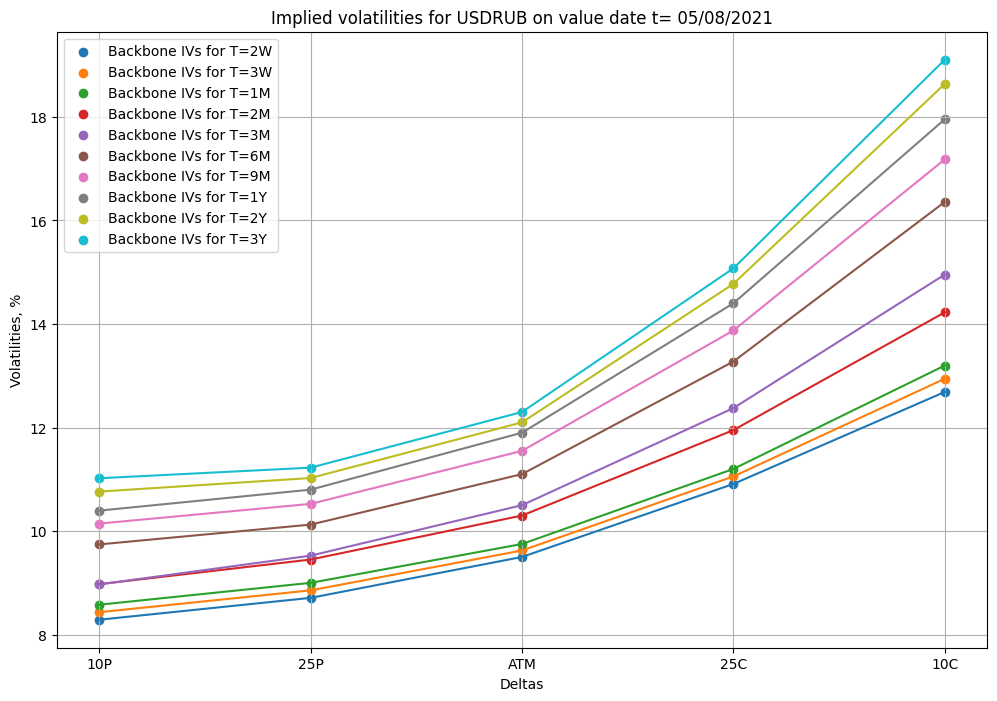

In [13]:
plt.figure(figsize=(12, 8))

for period_to_plot in volatiltiies["Periods"]:
    volatilities_per_delta_per_period = volatiltiies[volatiltiies["Periods"] == period_to_plot]
    vols_per_period = volatilities_per_delta_per_period[["10P", "25P", "ATM", "25C", "10C"]].values[0]
    deltas = ["10P", "25P", "ATM", "25C", "10C"]
    plt.plot(deltas, vols_per_period * 100)
    plt.scatter(deltas, vols_per_period * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Implied volatilities for USDRUB on value date t= " + value_date)
plt.xlabel("Deltas")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()

The strikes $K$ corresponding to given deltas can be found by solving the following equation

$$\Delta_{Forw}(K; F, \hat \sigma, T, \theta) \equiv \theta \cdot \Phi(\theta \cdot d_{+}) = \theta \cdot \Delta,$$

where $\Delta$ is either $0.1$ or $0.25$ and $\theta = 1$ if call and $-1$ if put, and 
$d_{+} = (\ln(F / K) + \hat \sigma^2 T / 2) / (\sigma \sqrt{T}).$

For that reason, we may define an objective function and corresponding minimization problem for each $T$ and $\Delta$: 

$$\argmin_{K} \text{Obj}(K) = \argmin_{K} (\Delta_{Forw}(K; F, \hat \sigma, T, \theta) - \theta \cdot \Delta)^2.$$

In [14]:
def forward_delta(F: float, K: float, sigma: float, t: float, is_call: bool):
    """Options forward delta in Black model.

    Args:
        F: forward.
        K: strike.
        sigma: implied volatility.
        t: time to maturity.
        isCall: type of option (True if Call, False if Put).
    """
    d = (np.log(F / K) + 0.5 * sigma**2 * t) / (sigma * np.sqrt(t))
    theta = 1.0 if is_call else -1.0
    return theta * norm.cdf(theta * d)

In [15]:
def period_to_float(period: str):
    """
    Converts period of string type aka 1W, 3M or 5Y to corresponding float representation. 

    Args:
        period: a string-type period. 
    """
    last_char = period[-1]
    if last_char == "W":
        return int(period[:-1]) * 1 / 12 / 4
    elif last_char == "M":
        return int(period[:-1]) * 1 / 12
    elif last_char == "Y":
        return int(period[:-1])

In [16]:
def objective(K: float, value: float, F: float, sigma: float, t: float, is_call: bool):
    """Options forward delta in Black model.

    Args:
        F: forward.
        K: strike.
        sigma: implied volatility.
        t: time to maturity.
        isCall: type of option (True if Call, False if Put).
    """
    return (forward_delta(F=F, K=K, sigma=sigma, t=t, is_call=is_call) - value)**2

In [17]:
def compute_strikes_for_corresponding_volatilities(volatilities: pd.DataFrame, forward: dict):
    """
    Matching the given delta by selecting the strike K. 

    Args:
        volatilities: a dataframe of voaltilities at given deltas. 
        forward: a date to forward mapping. 
    """
    volatilities_with_strikes = volatilities.copy(deep=True)
    periods = volatilities["Periods"]
    dates = volatilities["Dates"]
    is_call = True
    for delta in ["10P", "25P", "ATM", "25C", "10C"]:
        if delta == "ATM":
            volatilities_with_strikes[delta + "_K"] = [forward[date] for date in dates]
            continue
        is_call = False if delta[-1] == "P" else True
        sign = 1 if is_call else -1
        volatilities_per_delta = volatilities[delta]
        selected_strikes_per_delta = []
        for i, period in enumerate(periods):
            period_float = period_to_float(period)
            volatilities_per_delta_per_period = volatilities_per_delta[i]
            bounds = (forward[dates[i]], forward[dates[i]] * 1.5) if is_call else (forward[dates[i]] * 0.01, forward[dates[i]]) # in fact, this is not good, as we have to make some restrictive assumption on the ragne of strikes. 
            res = minimize_scalar(fun=objective, 
                                  args=(float(delta[:-1]) * 0.01 * sign, forward[dates[i]], volatilities_per_delta_per_period, period_float, is_call), 
                                  bounds=bounds, 
                                  method="bounded")
            selected_strikes_per_delta.append(res.x)
        volatilities_with_strikes[delta + "_K"] = selected_strikes_per_delta 
    return volatilities_with_strikes

In [18]:
volatilities_with_strikes = compute_strikes_for_corresponding_volatilities(volatilities=volatiltiies, forward=USDRUB_forward)

In [19]:
volatilities_with_strikes

,Dates,Periods,10P,25P,ATM,25C,10C,10P_K,25P_K,ATM_K,25C_K,10C_K
0,19/08/2021,2W,0.082875,0.08710,0.09500,0.10910,0.126875,71.650976,72.349575,73.210834,74.337255,75.706855
1,26/08/2021,3W,0.084325,0.08855,0.09625,0.11055,0.129425,71.357664,72.226916,73.295504,74.703160,76.438686
2,06/09/2021,1M,0.085775,0.09000,0.09750,0.11200,0.131975,71.157057,72.177571,73.428754,75.086863,77.158808
3,05/10/2021,2M,0.089750,0.09450,0.10300,0.11950,0.142250,70.454693,71.950452,73.792344,76.351712,79.627953
4,05/11/2021,3M,0.089700,0.09525,0.10500,0.12375,0.149550,70.120205,71.930061,74.193962,77.504121,81.884232
5,07/02/2022,6M,0.097425,0.10125,0.11100,0.13275,0.163575,69.238652,72.077748,75.450158,80.736536,88.092917
6,05/05/2022,9M,0.101450,0.10525,0.11550,0.13875,0.171800,68.742311,72.368792,76.638556,83.710715,93.769703
7,05/08/2022,1Y,0.103950,0.10800,0.11900,0.14400,0.179550,68.520520,72.815937,77.862756,86.698992,99.600724
8,07/08/2023,2Y,0.107625,0.11025,0.12100,0.14775,0.186375,68.616558,75.113445,82.434906,97.006084,119.644918
9,05/08/2024,3Y,0.110200,0.11225,0.12300,0.15075,0.191050,68.834121,77.158349,86.322978,106.516290,129.484457


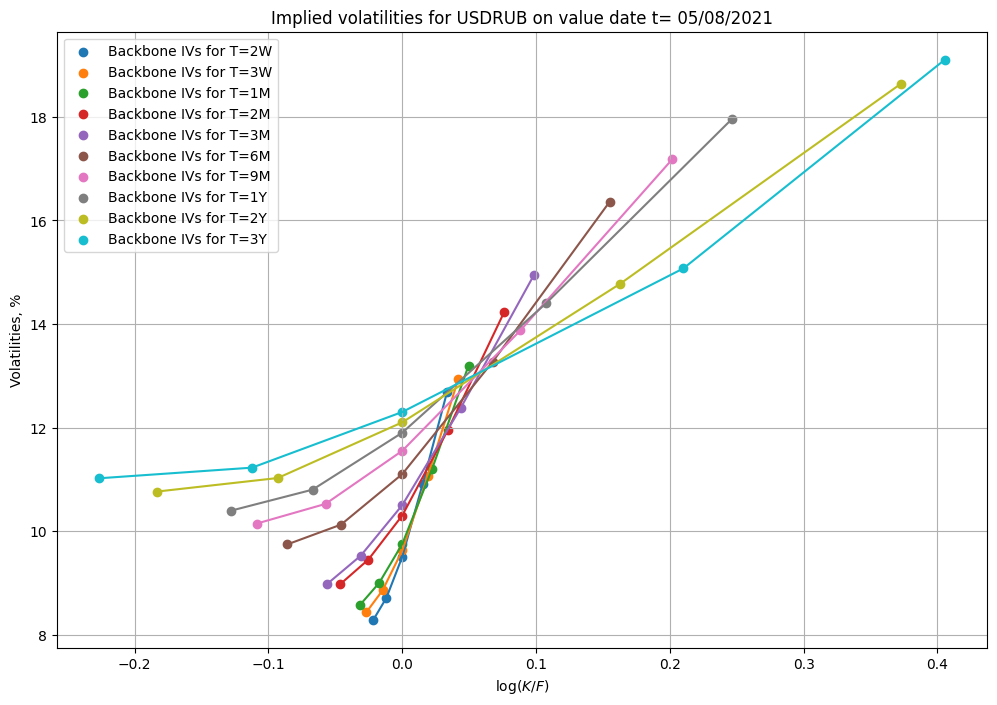

In [20]:
plt.figure(figsize=(12, 8))

for i, period_to_plot in enumerate(volatiltiies["Periods"]):
    volatilities_with_strikes_per_delta_per_period = volatilities_with_strikes[volatilities_with_strikes["Periods"] == period_to_plot]
    vols_per_period = volatilities_with_strikes_per_delta_per_period[["10P", "25P", "ATM", "25C", "10C"]].values[0]
    strikes_per_period = volatilities_with_strikes_per_delta_per_period[["10P_K", "25P_K", "ATM_K", "25C_K", "10C_K"]].values[0]
    log_moneyness_per_period = np.log(strikes_per_period / USDRUB_forward[volatiltiies["Dates"][i]])
    plt.plot(log_moneyness_per_period, vols_per_period * 100)
    plt.scatter(log_moneyness_per_period, vols_per_period * 100, label="Backbone IVs for T={}".format(period_to_plot))

plt.title("Implied volatilities for USDRUB on value date t= " + value_date)
plt.xlabel("$\log(K/F)$")
plt.ylabel("Volatilities, %")
plt.grid()
plt.legend()
plt.show()